In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import seaborn as sns
from scipy.stats import pointbiserialr

font_path = 'C:/Windows/Fonts/gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font) #폰트 설정 변경
# plt.rcParams['axes.unicode_minus']=False #마이너스 기호 깨질 때

## 데이터 로드, 음주 신체활동 관렴 칼럼만 추출

In [31]:
df = pd.read_csv('../../data/analy_data.csv')

In [32]:
# 음주 관련 칼럼
dr_start_loc = df.columns.get_loc('dra_01z1')
dr_end_loc = df.columns.get_loc('dre_04z1')

# 신체활동 관련 칼럼
ph_start_loc = df.columns.get_loc('pha_04z1')
ph_end_loc = df.columns.get_loc('pha_11z1')

In [33]:
# 음주 칼럼, 신체활동 칼럼, churn 칼럼만 추출해 저장
dr_ph_df = pd.concat([df.iloc[:, dr_start_loc:dr_end_loc+1], df.iloc[:, ph_start_loc:ph_end_loc+1], df[['churn']]], axis=1)

In [34]:
# NaN 없음 확인
dr_ph_df.isna().value_counts()

dra_01z1  drb_01z3  drb_03z1  drb_16z1  drb_04z1  drb_05z1  drg_01z3  dre_03z1  dre_04z1  pha_04z1  pha_05z1  pha_06z1  pha_07z1  pha_08z1  pha_09z1  phb_01z1  phb_02z1  phb_03z1  pha_11z1  churn
False     False     False     False     False     False     False     False     False     False     False     False     False     False     False     False     False     False     False     False    89822
Name: count, dtype: int64

## 데이터 1차 전처리 (비흡연자 row 제거, churn 데이터 생성)

In [35]:
# 일반담배, 전자담배, 그 외 담배를 과거에 피웠으나 현재 피우지 않는 (금연에 성공한) 사람의 row
# com_df = pd.read_csv('Community_Health_Survey_data.csv')
# anal_data = com_df[~((com_df['sma_03z2'] > 3.0) & (com_df['sma_12z2'] > 2.0) & (com_df['sma_37z1'] > 3.0))].reset_index(drop=True)
# # anal_data.to_csv('smoke_anal_data.csv', index=False, encoding='utf-8-sig')

In [36]:
df[['sma_03z2', 'sma_12z2', 'sma_37z1']]

,sma_03z2,sma_12z2,sma_37z1
0,3.0,3.0,8.0
1,1.0,3.0,8.0
2,3.0,3.0,8.0
3,1.0,3.0,8.0
4,1.0,3.0,8.0
...,...,...,...
89817,3.0,2.0,3.0
89818,3.0,3.0,8.0
89819,3.0,3.0,8.0
89820,1.0,2.0,3.0


In [37]:
anal_data = df.copy()

In [38]:
# 현재 흡연 여부: 하나라도 현재 피우고 있으면 흡연 중
currently_smoking = (
    anal_data['sma_03z2'].isin([1, 2]) |
    (anal_data['sma_12z2'] == 1) |
    anal_data['sma_37z1'].isin([1, 2])
)

# 과거 흡연 여부: 하나라도 과거에 피운 적 있으면 True
has_smoked_before = (
    (anal_data['sma_03z2'] == 3) |
    (anal_data['sma_12z2'] == 2) |
    (anal_data['sma_37z1'] == 3)
)

# 금연 성공자: 현재는 흡연 안 하고, 과거엔 피운 적 있음
anal_data['churn'] = np.where(
    (~currently_smoking) & has_smoked_before,
    1,
    0
)


In [39]:
anal_data[['sma_03z2', 'sma_12z2', 'sma_37z1', 'churn']].iloc[:20]

,sma_03z2,sma_12z2,sma_37z1,churn
0,3.0,3.0,8.0,1
1,1.0,3.0,8.0,0
2,3.0,3.0,8.0,1
3,1.0,3.0,8.0,0
4,1.0,3.0,8.0,0
5,3.0,3.0,8.0,1
6,3.0,3.0,8.0,1
7,3.0,3.0,1.0,0
8,3.0,3.0,8.0,1
9,3.0,3.0,8.0,1


In [ ]:
# ['sma_03z2', 'sma_12z2', 'sma_37z1']

anal_data['churn'] = np.where(
    (anal_data['sma_03z2'] == 3.0) & 
    (anal_data['sma_12z2'] >= 2.0) & 
    # (anal_data['sma_37z1'] == 3.0),
    1,  # 조건 만족 시
    0   # 조건 불만족 시
)
anal_data['churn'].value_counts()

In [41]:
anal_data[anal_data['sma_12z2'] >= 2]['sma_03z2'].value_counts()

sma_03z2
3.0    51949
1.0    33159
2.0     3482
8.0      318
9.0       20
Name: count, dtype: int64

## 음주, 신체활동, churn 상관관계 분석

#### 음주+churn 상관관계 분석

In [42]:
# info() 결측치 없음 확인
dr_ph_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89822 entries, 0 to 89821
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dra_01z1  89822 non-null  float64
 1   drb_01z3  89822 non-null  float64
 2   drb_03z1  89822 non-null  float64
 3   drb_16z1  89822 non-null  float64
 4   drb_04z1  89822 non-null  float64
 5   drb_05z1  89822 non-null  float64
 6   drg_01z3  89822 non-null  float64
 7   dre_03z1  89822 non-null  float64
 8   dre_04z1  89822 non-null  float64
 9   pha_04z1  89822 non-null  float64
 10  pha_05z1  89822 non-null  float64
 11  pha_06z1  89822 non-null  float64
 12  pha_07z1  89822 non-null  float64
 13  pha_08z1  89822 non-null  float64
 14  pha_09z1  89822 non-null  float64
 15  phb_01z1  89822 non-null  float64
 16  phb_02z1  89822 non-null  float64
 17  phb_03z1  89822 non-null  float64
 18  pha_11z1  89822 non-null  float64
 19  churn     89822 non-null  int64  
dtypes: float64(19), int64(1)
mem

In [43]:
# 최근 1년 동안 음주 경험 + churn 관계
dr_ph_df[['dra_01z1', 'churn']].value_counts()

# 아니오(2)로 답한 사람은 음주 관련 설문 미실시 (하위 질문 '비해당(8)' 처리)

dra_01z1  churn
1.0       1        46427
          0        37875
2.0       1         2824
          0         2696
Name: count, dtype: int64

In [44]:
# 연간 음주량
print(dr_ph_df[['drb_01z3', 'churn']].value_counts())
# 최근 1년간 전혀 마시지 않았다 + 금연 성공이 12325로 제일 많음
# 한 달에 2~4번 정도 + 금연 성공이 10382로 두 번째로 많음
# 일주일에 2~3번 정도 + 금연 성공이 9112

# 일주일에 2~3번 정도 + 흡연 중이 9434로, 흡연 중인 사람에 대해 제일 높은 음주 빈도를 보임
# 흡연 중인 사람에 대해 한 달에 2~4번 정도가 두 번째로 높은 음주 빈도를 보임


# 비해당(평생 음주 경험 조사에서 2번을 찍은 row) 8번: 5520(2824, 2696)
print(dr_ph_df[dr_ph_df['drb_01z3']==8]['churn'].value_counts())

drb_01z3  churn
1.0       1        12325
4.0       1        10382
5.0       0         9741
4.0       0         9434
5.0       1         9112
6.0       0         6405
2.0       1         5277
6.0       1         5147
1.0       0         4972
3.0       1         4183
2.0       0         3964
3.0       0         3358
8.0       1         2824
          0         2696
7.0       1            1
          0            1
Name: count, dtype: int64
churn
1    2824
0    2696
Name: count, dtype: int64


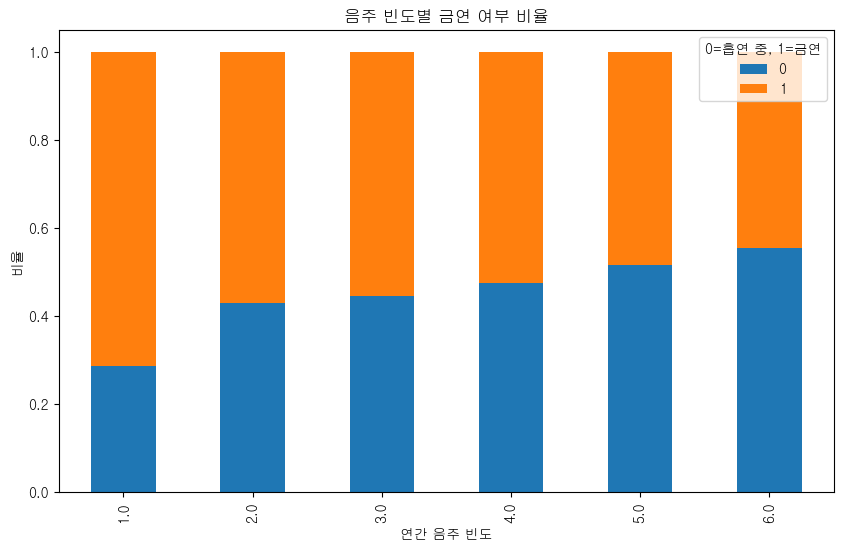

In [45]:
# 위 value_counts를 비율막대그래프로 시각화

# 값 집계
count_df = dr_ph_df.groupby(['drb_01z3', 'churn']).size().unstack(fill_value=0)

# 존재하지 않는 칼럼값인 7 제거
count_df = count_df.drop(index=7, errors='ignore')
# '비해당'인 칼럼값 8 제거
count_df = count_df.drop(index=8, errors='ignore')

# 비율 정규화
ratio_df = count_df.div(count_df.sum(axis=1), axis=0)

# 비율 스택 그래프
ratio_df.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('음주 빈도별 금연 여부 비율')
plt.xlabel('연간 음주 빈도')
plt.ylabel('비율')
plt.legend(title='0=흡연 중, 1=금연')
plt.show()


In [46]:
# 한 번 섭취 시 음주량 + churn
# 비해당 22817 : 최근 1년 동안 술을 마시지 않은 row + 최근 1년간 전혀 마시지 않은 row 개수
print(dr_ph_df[['drb_03z1', 'churn']].value_counts())
# 

drb_03z1  churn
8.0       1        15149
4.0       0         9967
5.0       0         8778
4.0       1         8542
1.0       1         8166
8.0       0         7668
2.0       1         7440
5.0       1         5409
2.0       0         5387
3.0       0         4865
          1         4543
1.0       0         3905
7.0       0            1
          1            1
9.0       1            1
Name: count, dtype: int64


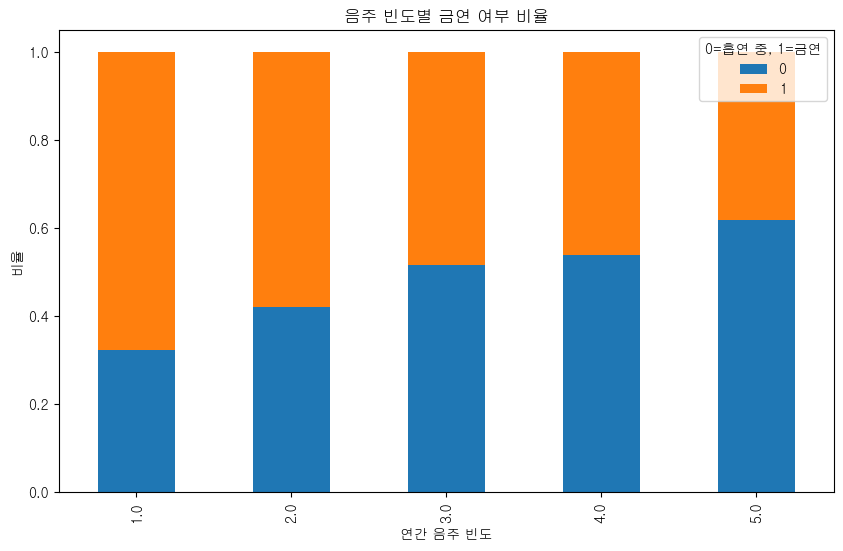

In [47]:
# 위 value_counts를 비율막대그래프로 시각화

# 값 집계
count_df = dr_ph_df.groupby(['drb_03z1', 'churn']).size().unstack(fill_value=0)

# 존재하지 않는 칼럼값인 7 제거
count_df = count_df.drop(index=7, errors='ignore')
# '비해당'인 칼럼값 8 제거
count_df = count_df.drop(index=8, errors='ignore')
# '모름'인 칼럼값 9 제거
count_df = count_df.drop(index=9, errors='ignore')

# 비율 정규화
ratio_df = count_df.div(count_df.sum(axis=1), axis=0)

# 비율 스택 그래프
ratio_df.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('음주 빈도별 금연 여부 비율')
plt.xlabel('연간 음주 빈도')
plt.ylabel('비율')
plt.legend(title='0=흡연 중, 1=금연')
plt.show()


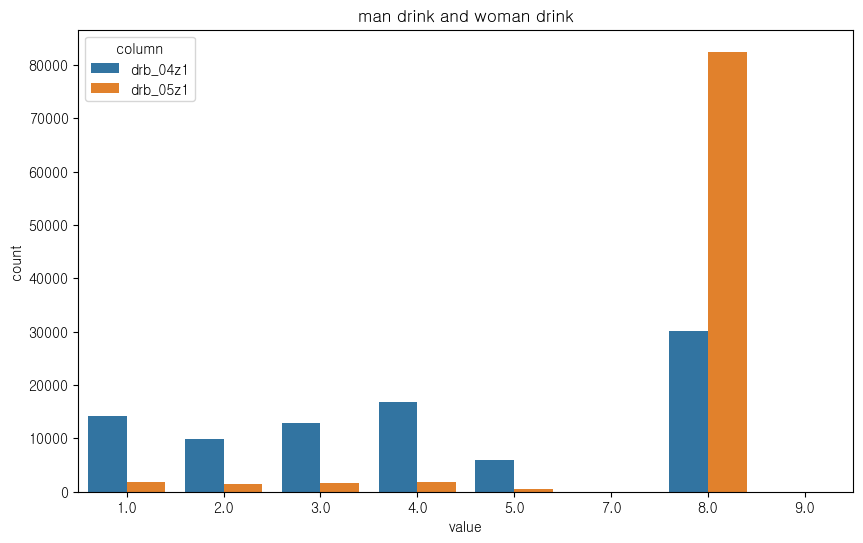

In [48]:
# 월간 폭음 경험(남), 월간 폭음 경험(여) barplot

cols = ['drb_04z1', 'drb_05z1']

# 두 컬럼의 값별 빈도수를 하나의 DataFrame으로 변환
df_melted = dr_ph_df[cols].melt(var_name='column', value_name='value')

# 값별 count 세기
plot_data = df_melted.value_counts().reset_index(name='count')

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_data, x='value', y='count', hue='column')
plt.title("man drink and woman drink")
plt.xlabel("value")
plt.ylabel("count")
plt.show()

# 남성 빈도가 대체적으로 높으나, 설문 대상의 남여 비율이 1:1인지 확인 필요
# 인사이트 도출은 가능하지만 관련된 해결책 제시 불가.

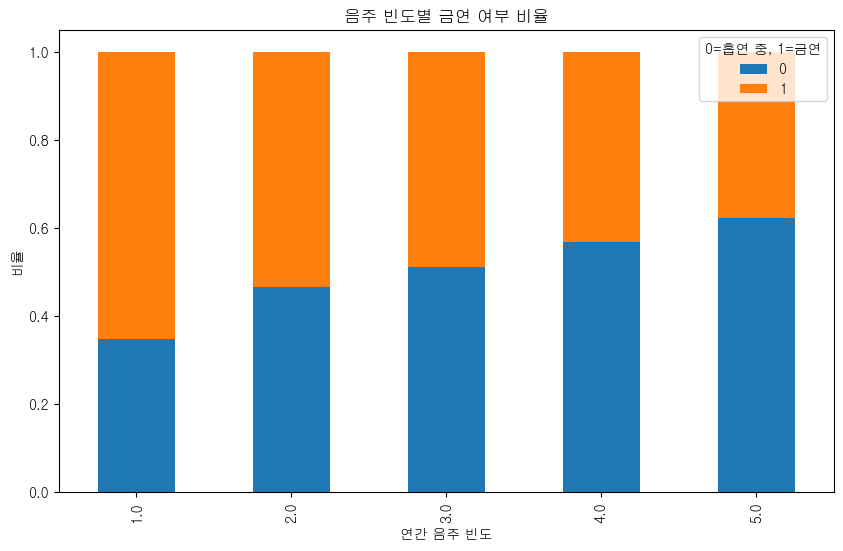

churn        0     1
drb_04z1            
1.0       4920  9241
2.0       4611  5258
3.0       6571  6253
4.0       9527  7256
5.0       3743  2269


In [49]:
# '월간 폭음 경험(남)'에 대한 비율 그래프

# 값 집계
count_df = dr_ph_df.groupby(['drb_04z1', 'churn']).size().unstack(fill_value=0)

# 존재하지 않는 칼럼값인 7 제거
count_df = count_df.drop(index=7, errors='ignore')
# '비해당'인 칼럼값 8 제거
count_df = count_df.drop(index=8, errors='ignore')
# '모름'인 칼럼값 9 제거
count_df = count_df.drop(index=9, errors='ignore')

# 비율 정규화
ratio_df = count_df.div(count_df.sum(axis=1), axis=0)

# 비율 스택 그래프
ratio_df.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('음주 빈도별 금연 여부 비율')
plt.xlabel('연간 음주 빈도')
plt.ylabel('비율')
plt.legend(title='0=흡연 중, 1=금연')
plt.show()

print(count_df)

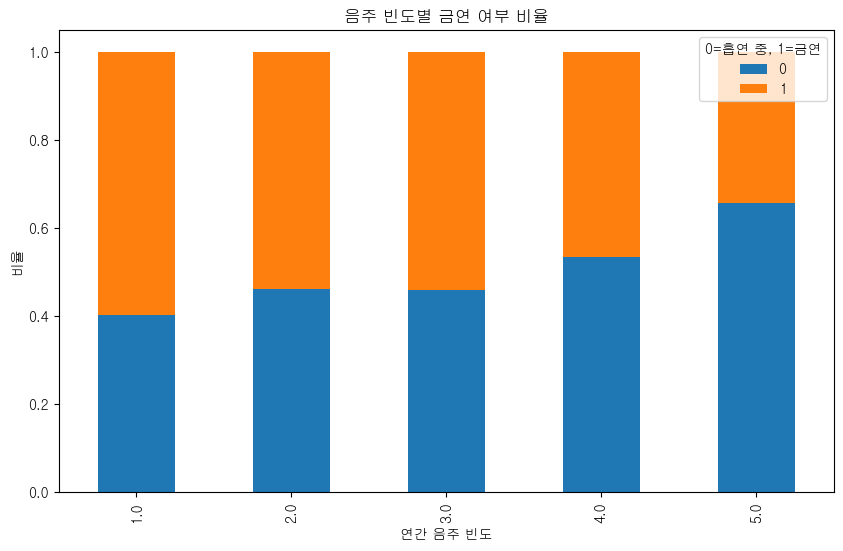

churn        0     1
drb_05z1            
1.0        745  1102
2.0        685   801
3.0        719   848
4.0       1011   882
5.0        367   191


In [50]:
# '월간 폭음 경험(여)'에 대한 비율 그래프

# 값 집계
count_df = dr_ph_df.groupby(['drb_05z1', 'churn']).size().unstack(fill_value=0)

# 존재하지 않는 칼럼값인 7 제거
count_df = count_df.drop(index=7, errors='ignore')
# '비해당'인 칼럼값 8 제거
count_df = count_df.drop(index=8, errors='ignore')
# '모름'인 칼럼값 9 제거
count_df = count_df.drop(index=9, errors='ignore')

# 비율 정규화
ratio_df = count_df.div(count_df.sum(axis=1), axis=0)

# 비율 스택 그래프
ratio_df.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('음주 빈도별 금연 여부 비율')
plt.xlabel('연간 음주 빈도')
plt.ylabel('비율')
plt.legend(title='0=흡연 중, 1=금연')
plt.show()

print(count_df)


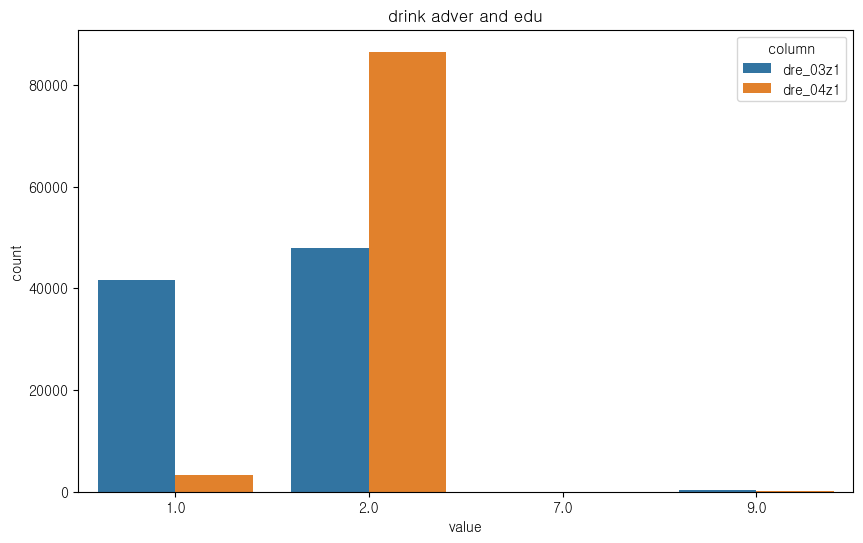

In [51]:
# 음주폐해 예방 또는 절주에 대한 홍보 경험 & 교육 경험 여부

cols = ['dre_03z1', 'dre_04z1']

df_melted = dr_ph_df[cols].melt(var_name='column', value_name='value')

plot_data = df_melted.value_counts().reset_index(name='count')

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_data, x='value', y='count', hue='column')
plt.title("drink adver and edu")
plt.xlabel("value")
plt.ylabel("count")
plt.show()

# 교육 경험이 없는 사람이 매우 많음

In [52]:
# 홍보 and 교육 경험이 있던 사람의 음주 빈도
df_filtered = dr_ph_df[(dr_ph_df['dre_03z1']==1) | (dr_ph_df['dre_04z1']==1)]
print(f'홍보와 교육 경험이 있던 사람 중 최근 1년 동안 음주 안 한 비율: {df_filtered[df_filtered['dra_01z1']==1]['dra_01z1'].count()/df_filtered['dra_01z1'].count()}')
# 0.95... ...


# 홍보 or 교육 경험이 없는 사람의 음주 빈도
df_filtered = dr_ph_df[(dr_ph_df['dre_03z1']==2) | (dr_ph_df['dre_04z1']==2)]
print(f'홍보나 교육 경험이 없던 사람 중 최근 1년 동안 음주를 한 비율: {df_filtered[df_filtered['dra_01z1']==1]['dra_01z1'].count()/df_filtered['dra_01z1'].count()}')
# 0.93 ;;;

# 긍정적인 결과 나온다면 금연도 홍보 or 교육으로 이뤄질 수 있다는 인사이트 도출 가능
# 불가할듯.

홍보와 교육 경험이 있던 사람 중 최근 1년 동안 음주 안 한 비율: 0.9490618534636512
홍보나 교육 경험이 없던 사람 중 최근 1년 동안 음주를 한 비율: 0.9372442646315112


In [53]:
# 'drg_01z3':	'절주 또는 금주계획 여부'

dr_ph_df.groupby('drg_01z3')['churn'].value_counts()

drg_01z3  churn
1.0       0        24874
          1        24792
2.0       0         3971
          1         3551
3.0       1         1143
          0          954
4.0       1         1724
          0         1265
5.0       1         2888
          0         1835
7.0       0            2
          1            2
8.0       1        15149
          0         7668
9.0       0            2
          1            2
Name: count, dtype: int64

##### 중간 정리 1
- 흡연 경험이 있는 사람 (89822) 중 음주 경험도 있는 사람이 84302

- 평생 음주를 안 해본 사람 중 금연 성공인이 2824, 흡연자는 2696 (거의 반반. 음주를 안 하는 사람이 금연 성공율 높다는 결과 도출 불가)

- 금연 성공(churn 1)한 row에 대해, 가장 높은 `연간 음주 빈도` 값은 1 (최근 1년간 전혀 마시지 않았다)
- 금연 실패(churn 0)인 row에 대해, 가장 높은 `연간 음주 빈도` 값은 5 (일주일에 2~3번 정도)
- -> 비율막대그래프로 시각화. 연간 음주 빈도가 잦아질수록 churn 1보다 churn 0의 비율이 늘어남

- 남여 모두 월간 폭음 경험이 잦을수록 흡연자 비율이 높아짐

- 음주폐해 예방 또는 절주에 대한 홍보 경험 & 교육 경험 여부로 음주 빈도 차이 보이지 않음

- 현재 절주 또는 음주 계획이 전혀 없는 응답 중 흡연자, 금연자 비율이 거의 비슷. 3, 4, 5 응답에 대해선 근소하게 금연자가 더 많음.

#### 신체활동 + churn 상관관계 분석

In [54]:
# 운동 관련 칼럼에서 77: 응답거부, 99: 모름 답변 제거

# 운동 관련 컬럼 목록
activity_cols = {
    'pha_04z1':'고강도 신체활동', #'고강도 신체활동 일수'
    # '고강도 신체활동 시간(시)',
    # '고강도 신체활동 시간(분)',
    'pha_07z1':'중강도 신체활동', # '중강도 신체활동 일수'
    # '중강도 신체활동 시간(시)',
    # '중강도 신체활동 시간(분)',
    'phb_01z1':'걷기 활동', #'걷기 실천 일수'
    # '걷기 실천 시간(시)',
    # '걷기 실천 시간(분)'
}
# 시간과 분은 각 활동이 '있었을 때'를 상정한 부가적 설문이었으므로 활용x

cols_to_check = list(activity_cols.keys())
df_filtered = dr_ph_df[~(dr_ph_df[cols_to_check] >= 77).any(axis=1)].reset_index(drop=True)

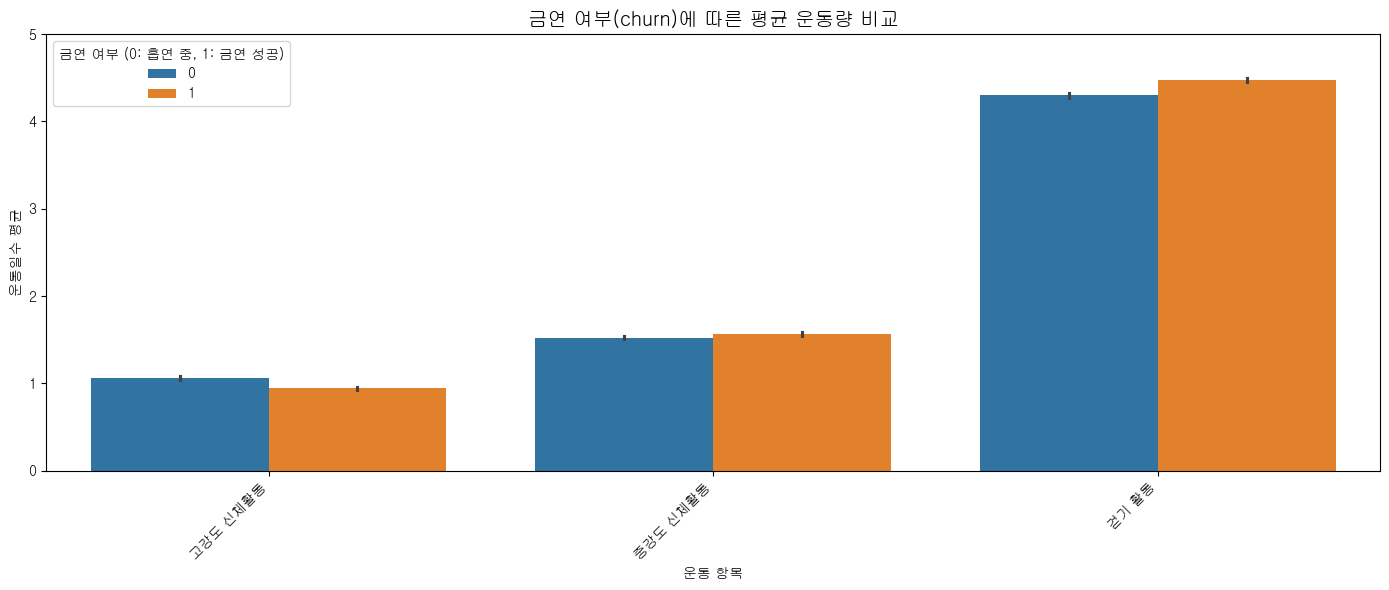

In [55]:
# churn별 각 운동일수 평균
# melt로 long-form 변환
df_melted = df_filtered.melt(id_vars='churn', value_vars=activity_cols.keys(),
                            var_name='운동종류', value_name='운동일수평균')

df_melted['운동종류'] = df_melted['운동종류'].map(activity_cols)

# 결측치 제거
df_melted = df_melted.dropna()

# 시각화
plt.figure(figsize=(14, 6))
sns.barplot(data=df_melted, x='운동종류', y='운동일수평균', hue='churn')

plt.title("금연 여부(churn)에 따른 평균 운동량 비교", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.xlabel("운동 항목")
plt.ylabel("운동일수 평균")
plt.legend(title='금연 여부 (0: 흡연 중, 1: 금연 성공)')
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

##### 중간 정리 2
- 고강도 77이상값: 없음, 중강도 77이상값: 2(99), 걷기 77이상값: 4(99)

- 고강도, 중강도, 걷기 운동에 대해 평균값 비교시 눈에 띄는 차이 확인 어려움
- -> 금연자가 높은 운동량을 가지진 않음

In [56]:
# 신체활동 칼럼 값 분포 확인

for col in activity_cols:
    print(df_filtered.groupby(col)[['churn']].count())

          churn
pha_04z1       
0.0       63356
1.0        5462
2.0        5180
3.0        5276
4.0        2337
5.0        3875
6.0        1347
7.0        2983
          churn
pha_07z1       
0.0       54306
1.0        4742
2.0        5982
3.0        7047
4.0        2831
5.0        6282
6.0        2070
7.0        6556
          churn
phb_01z1       
0.0       15624
1.0        3198
2.0        6022
3.0        8345
4.0        4545
5.0       12194
6.0        4194
7.0       35694


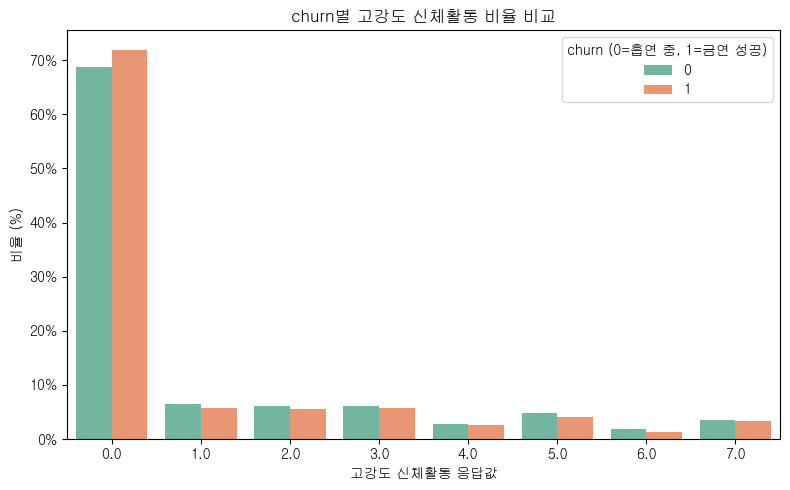

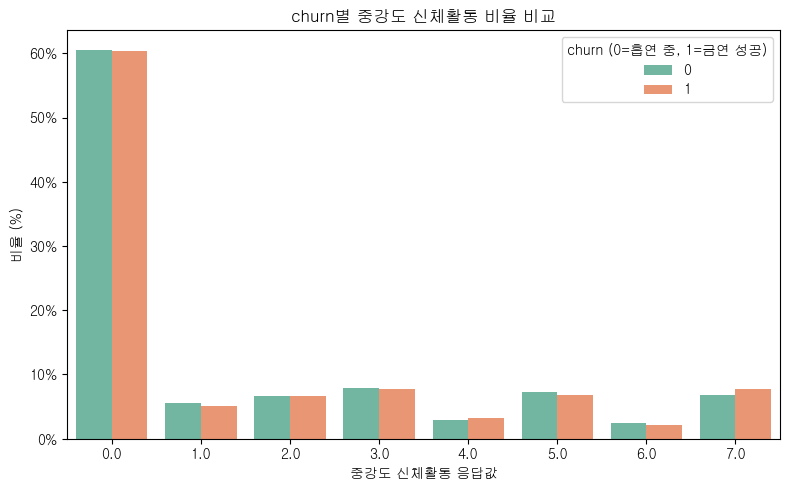

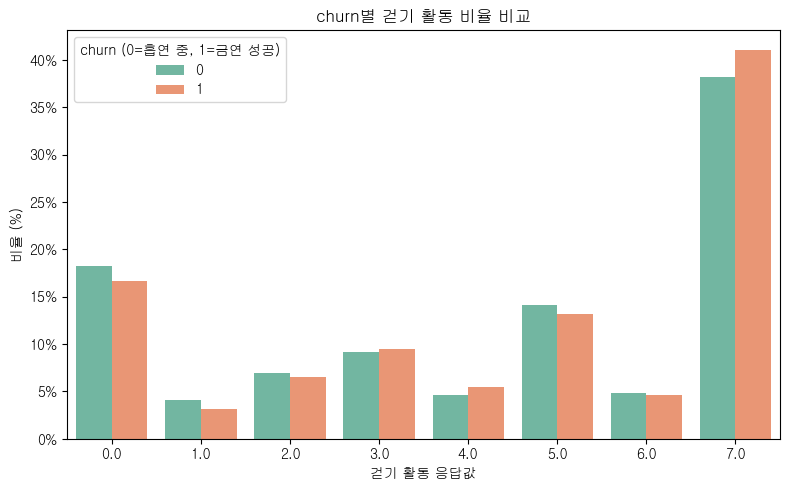

In [57]:
# 신체활동 칼럼마다 분포 확인

import warnings
warnings.filterwarnings('ignore')
#warning 메세지 무시 코드(출력 안 됨)

for col in activity_cols:
    # 각 churn 그룹 내에서 비율 계산
    # 개수 집계
    count_df = df_filtered.groupby(['churn', col]).size().reset_index(name='count')

    # churn 그룹별 총합 구해서 비율 계산
    count_df['total'] = count_df.groupby('churn')['count'].transform('sum')
    count_df['rate'] = count_df['count'] / count_df['total']

    # 시각화
    plt.figure(figsize=(8, 5))
    sns.barplot(data=count_df, x=col, y='rate', hue='churn', palette='Set2')

    plt.title(f'churn별 {activity_cols[col]} 비율 비교')
    plt.xlabel(f'{activity_cols[col]} 응답값')
    plt.ylabel('비율 (%)')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))  # y축 퍼센트 표시
    plt.legend(title='churn (0=흡연 중, 1=금연 성공)')
    plt.tight_layout()
    plt.show()


##### 중간 정리 3
- 고강도, 중강도 운동 모두 안 하는 사람 중 금연자 비율이 오히려 높음
- 걷기 운동에 대해선 금연자가 높은 운동량 보임

pha_04z1의 churn=0: 0.31181443959673644
pha_04z1의 churn=1: 0.28042317298515645


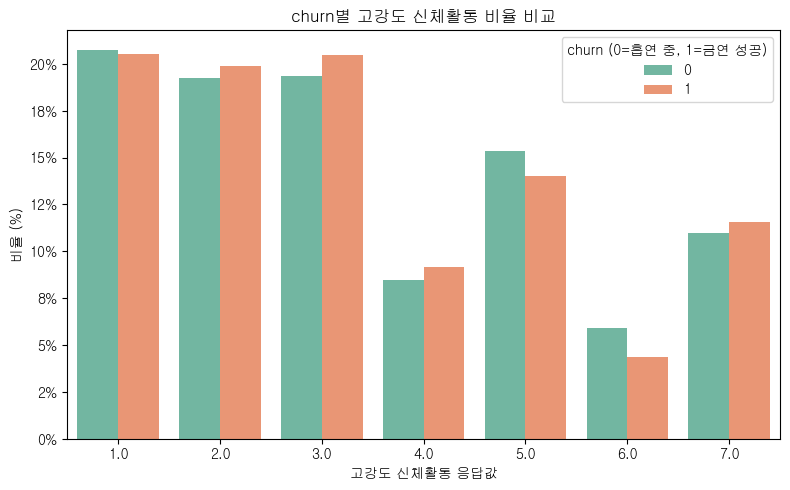

pha_07z1의 churn=0: 0.39446375311198206
pha_07z1의 churn=1: 0.39612565232399943


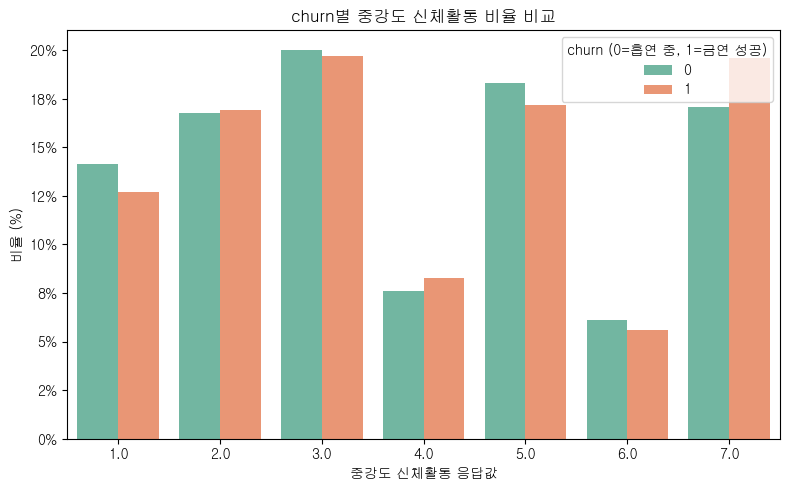

phb_01z1의 churn=0: 0.817372870911287
phb_01z1의 churn=1: 0.8332081141998497


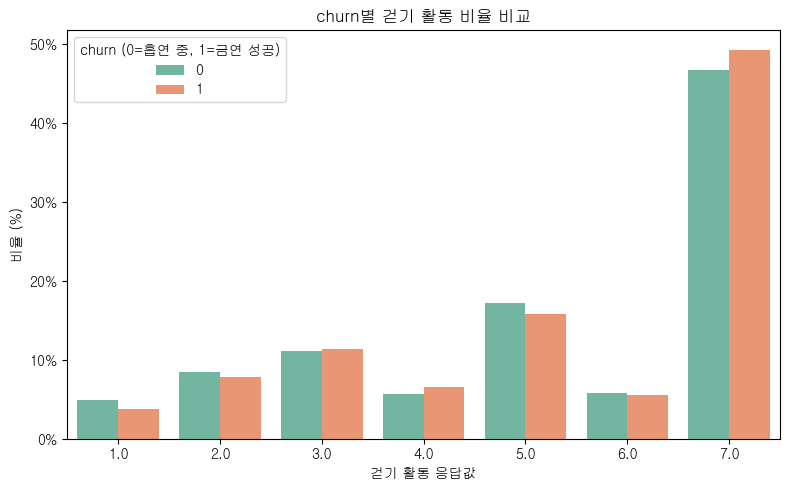

In [58]:
# 신체활동 칼럼마다 분포 확인 + 운동을 안하는 (칼럼값 0) 값 제외

for col in activity_cols:
    # 0 값 제거
    df_filtered_nozero = dr_ph_df[(dr_ph_df[col] < 77) & (dr_ph_df[col]!=0)]

    # 각 churn 그룹 내에서 비율 계산
    # 개수 집계
    count_df = df_filtered_nozero.groupby(['churn', col]).size().reset_index(name='count')

    # churn 그룹별 총합 구해서 비율 계산
    count_df['total'] = count_df.groupby('churn')['count'].transform('sum')
    count_df['rate'] = count_df['count'] / count_df['total']

    # churn별 해당 운동을 하루 이상 하는 사람 비율
    for churn_value in [0, 1]:
        count = df_filtered_nozero[(df_filtered_nozero['churn'] == churn_value)&(df_filtered_nozero[col].between(1, 7))].shape[0]
        
        # churn별 총 사람 수로 나누어 비율 계산
        # 운동을 아예 안 하는 사람도 포함되어 있음, 77이상 값은 포함x
        print(f"{col}의 churn={churn_value}: {count/df_filtered[df_filtered['churn']==churn_value]['churn'].count()}")

    # 시각화
    plt.figure(figsize=(8, 5))
    sns.barplot(data=count_df, x=col, y='rate', hue='churn', palette='Set2')

    plt.title(f'churn별 {activity_cols[col]} 비율 비교')
    plt.xlabel(f'{activity_cols[col]} 응답값')
    plt.ylabel('비율 (%)')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))  # y축 퍼센트 표시
    plt.legend(title='churn (0=흡연 중, 1=금연 성공)')
    plt.tight_layout()
    plt.show()


In [59]:
# 고강도, 중강도, 걷기 중 하나라도 하는 사람의 churn별 비율

count_df = df_filtered[(df_filtered['pha_04z1']>0) | (df_filtered['pha_07z1']>0) | (df_filtered['phb_01z1']>0)].groupby('churn')['churn'].count()
print(count_df[0]/df_filtered[df_filtered['churn']==0]['churn'].count())
print(count_df[1]/df_filtered[df_filtered['churn']==1]['churn'].count())

0.8888806724346175
0.898755254127155


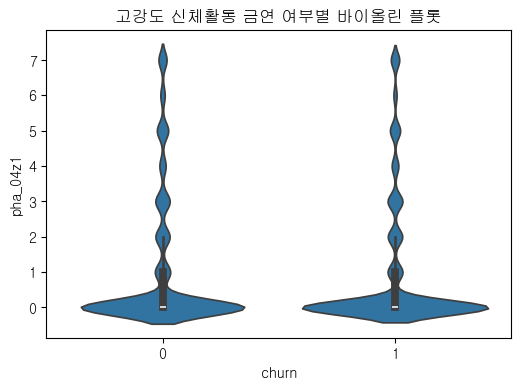

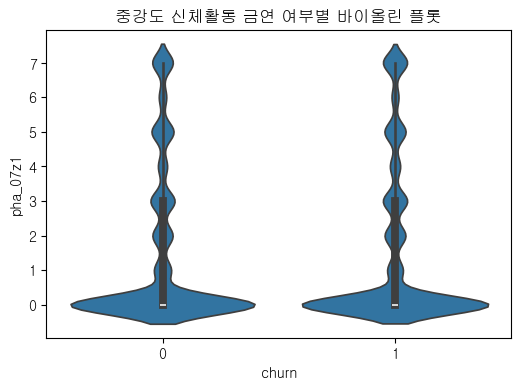

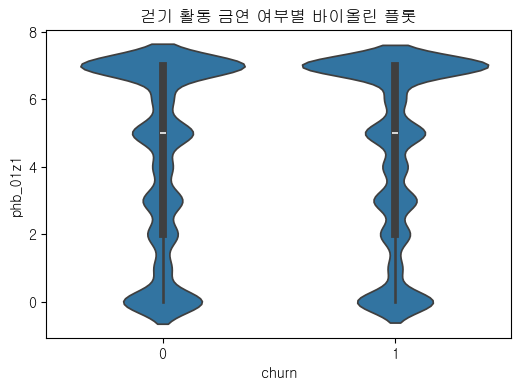

In [60]:
# 위의 바플롯을 바이올린 플롯으로 시각화

for col in activity_cols:
    plt.figure(figsize=(6,4))

    sns.violinplot(x='churn', y=col, data=df_filtered)
    plt.title(f'{activity_cols[col]} 금연 여부별 바이올린 플롯')
    plt.show()


In [ ]:
dr_ph_df['고강도운동시간'] = (
    dr_ph_df.loc[dr_ph_df['pha_05z1'] < 77, 'pha_05z1'].fillna(0) * 60
    + dr_ph_df.loc[dr_ph_df['pha_06z1'] < 77, 'pha_06z1'].fillna(0)
)


In [76]:
dr_ph_df['고강도운동시간'].value_counts()

고강도운동시간
60.0     7540
120.0    4531
30.0     3447
90.0     2467
180.0    1765
         ... 
310.0       1
128.0       1
85.0        1
122.0       1
48.0        1
Name: count, Length: 76, dtype: int64

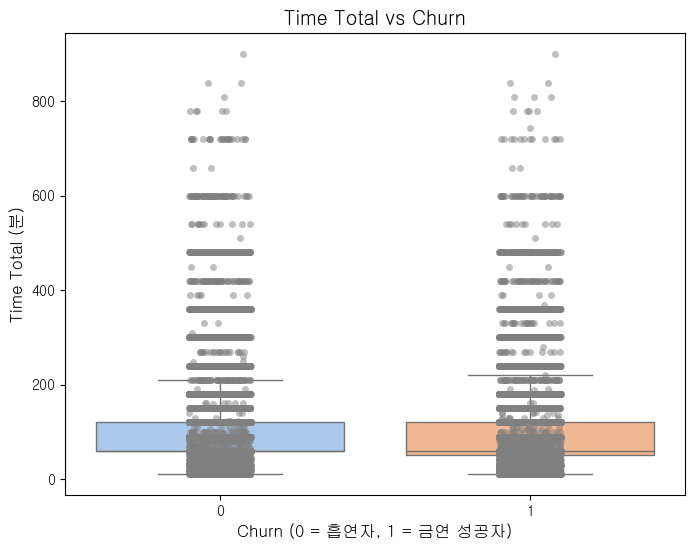

In [78]:
plt.figure(figsize=(8,6))

df_test = dr_ph_df.dropna()

sns.boxplot(data=df_test, x='churn', y='고강도운동시간', showfliers=False, palette='pastel')
sns.stripplot(data=df_test, x='churn', y='고강도운동시간', color='gray', alpha=0.5, jitter=True)

plt.title('Time Total vs Churn', fontsize=14)
plt.xlabel('Churn (0 = 흡연자, 1 = 금연 성공자)', fontsize=12)
plt.ylabel('Time Total (분)', fontsize=12)
plt.show()


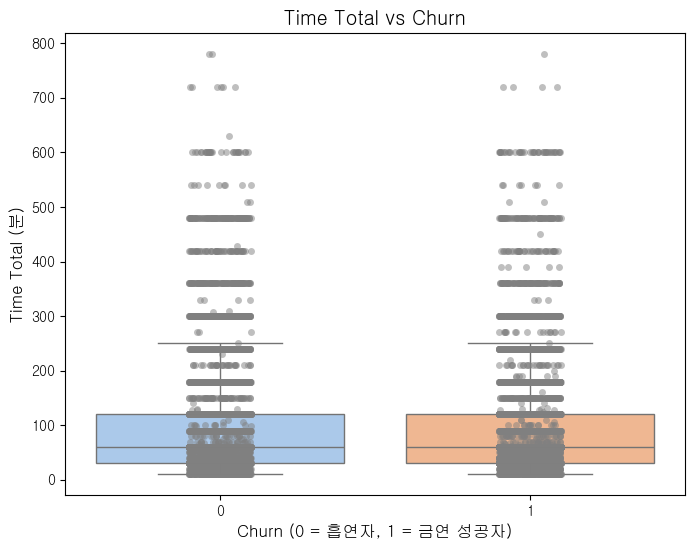

In [80]:
dr_ph_df['중강도운동시간'] = (
    dr_ph_df.loc[dr_ph_df['pha_08z1'] < 77, 'pha_08z1'].fillna(0) * 60
    + dr_ph_df.loc[dr_ph_df['pha_09z1'] < 77, 'pha_09z1'].fillna(0)
)
plt.figure(figsize=(8,6))

df_test = dr_ph_df.dropna()

sns.boxplot(data=df_test, x='churn', y='중강도운동시간', showfliers=False, palette='pastel')
sns.stripplot(data=df_test, x='churn', y='중강도운동시간', color='gray', alpha=0.5, jitter=True)

plt.title('Time Total vs Churn', fontsize=14)
plt.xlabel('Churn (0 = 흡연자, 1 = 금연 성공자)', fontsize=12)
plt.ylabel('Time Total (분)', fontsize=12)
plt.show()


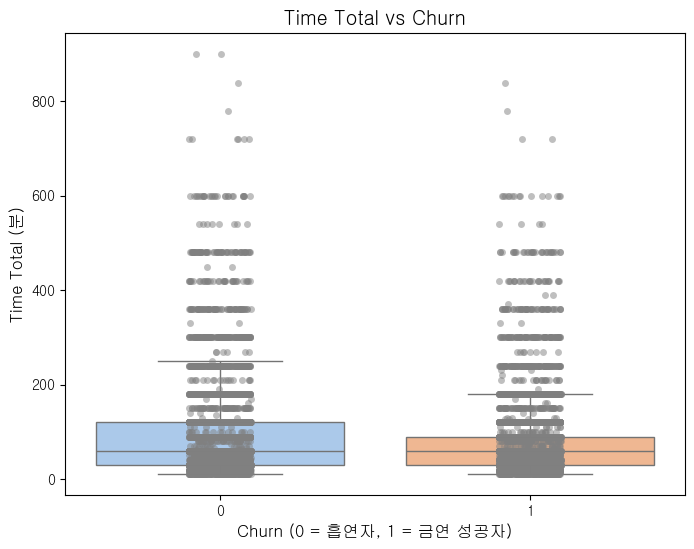

In [81]:
dr_ph_df['걷기시간'] = (
    dr_ph_df.loc[dr_ph_df['phb_02z1'] < 77, 'phb_02z1'].fillna(0) * 60
    + dr_ph_df.loc[dr_ph_df['phb_03z1'] < 77, 'phb_03z1'].fillna(0)
)
plt.figure(figsize=(8,6))

df_test = dr_ph_df.dropna()

sns.boxplot(data=df_test, x='churn', y='걷기시간', showfliers=False, palette='pastel')
sns.stripplot(data=df_test, x='churn', y='걷기시간', color='gray', alpha=0.5, jitter=True)

plt.title('Time Total vs Churn', fontsize=14)
plt.xlabel('Churn (0 = 흡연자, 1 = 금연 성공자)', fontsize=12)
plt.ylabel('Time Total (분)', fontsize=12)
plt.show()

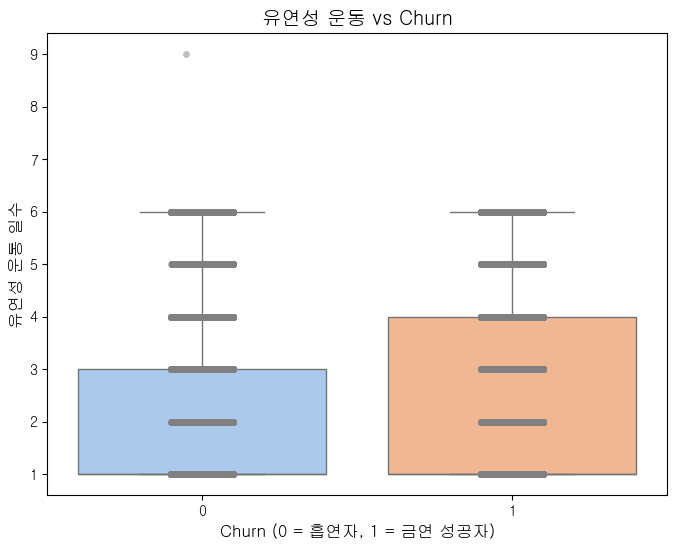

In [86]:

plt.figure(figsize=(8,6))

df_test = dr_ph_df.copy()

sns.boxplot(data=df_test, x='churn', y='pha_11z1', showfliers=False, palette='pastel')
sns.stripplot(data=df_test, x='churn', y='pha_11z1', color='gray', alpha=0.5, jitter=True)

plt.title('유연성 운동 vs Churn', fontsize=14)
plt.xlabel('Churn (0 = 흡연자, 1 = 금연 성공자)', fontsize=12)
plt.ylabel('유연성 운동 일수', fontsize=12)
plt.show()

##### 중간 정리 4
- 흡연자, 금연자의 운동빈도 역시 눈에 띄는 차이 x
- 세 종목 운동에 대해 하루 이상 하는 사람 비율이 금연자가 근소하게 많음
- 고강도, 중강도, 걷기 실천 시간은 큰 차이 보이지 않음

#### 음주, 신체활동 상관계수 시각화

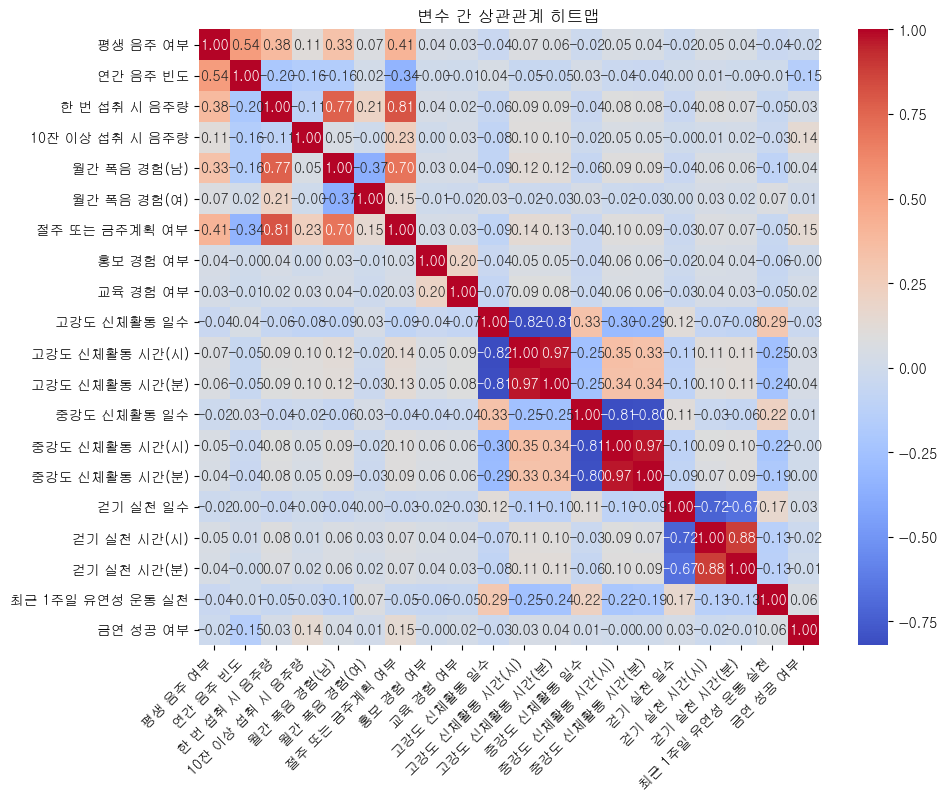

In [ ]:
columns = {
    'dra_01z1':	'평생 음주 여부',
    'drb_01z3':	'연간 음주 빈도',
    'drb_03z1':	'한 번 섭취 시 음주량',
    'drb_16z1':	'10잔 이상 섭취 시 음주량',
    'drb_04z1':	'월간 폭음 경험(남)',
    'drb_05z1':	'월간 폭음 경험(여)',
    'drg_01z3':	'절주 또는 금주계획 여부',
    'dre_03z1':	'홍보 경험 여부',
    'dre_04z1':	'교육 경험 여부',
    'pha_04z1':	'고강도 신체활동 일수',
    'pha_05z1':	'고강도 신체활동 시간(시)',
    'pha_06z1':	'고강도 신체활동 시간(분)',
    'pha_07z1':	'중강도 신체활동 일수',
    'pha_08z1':	'중강도 신체활동 시간(시)',
    'pha_09z1':	'중강도 신체활동 시간(분)',
    'phb_01z1':	'걷기 실천 일수',
    'phb_02z1':	'걷기 실천 시간(시)',
    'phb_03z1':	'걷기 실천 시간(분)',
    'pha_11z1':	'최근 1주일 유연성 운동 실천',
    'churn': '금연 성공 여부'
}

corr = dr_ph_df.corr()

corr.rename(index=columns, columns=columns, inplace=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('변수 간 상관관계 히트맵')
plt.show()

# 고강도, 중강도 운동에 약한 양의 상관관계
# 고강도, 중강도, 걷기 관련 칼럼이 각각 강한 상관관계 보이므로 (시간), (분) 칼럼은 모델 학습에서 제외

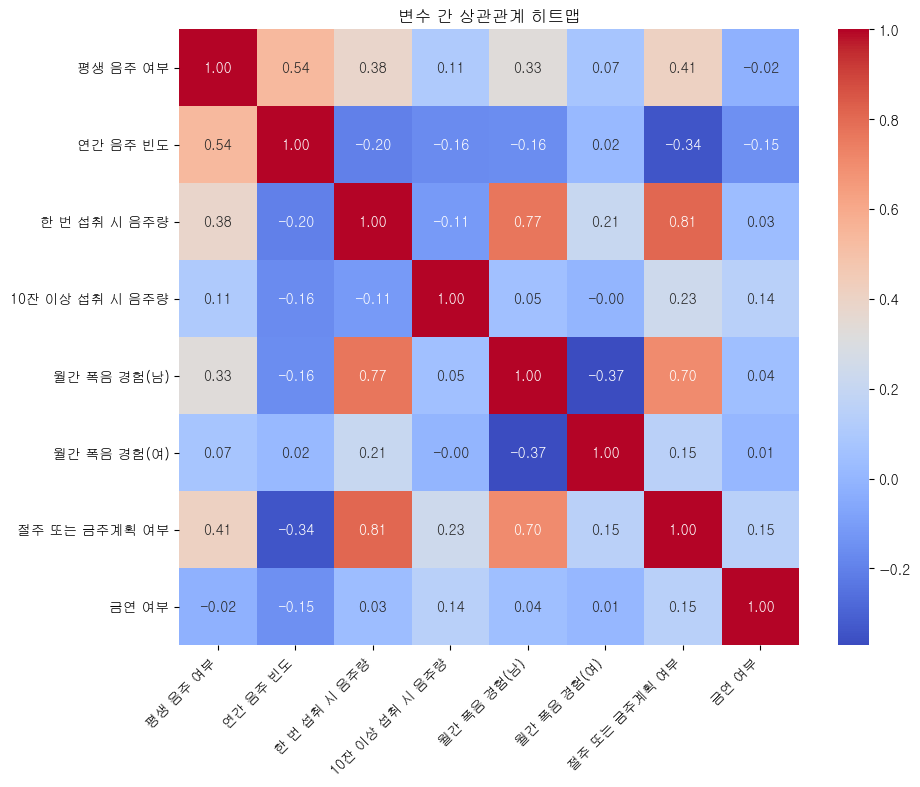

In [65]:
# 평생 음주 여부 ~ 절주 또는 음주계획 여부 칼럼만 빼서 시각화

# 사용할 칼럼만 추출
sub_columns = dict(list(columns.items())[:7])
cols_to_check = list(sub_columns.keys())

# churn 추가
sub_columns['churn']='금연 여부'
cols_to_check.append('churn')

corr = dr_ph_df[cols_to_check].corr()

corr.rename(index=sub_columns, columns=sub_columns, inplace=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('변수 간 상관관계 히트맵')
plt.show()

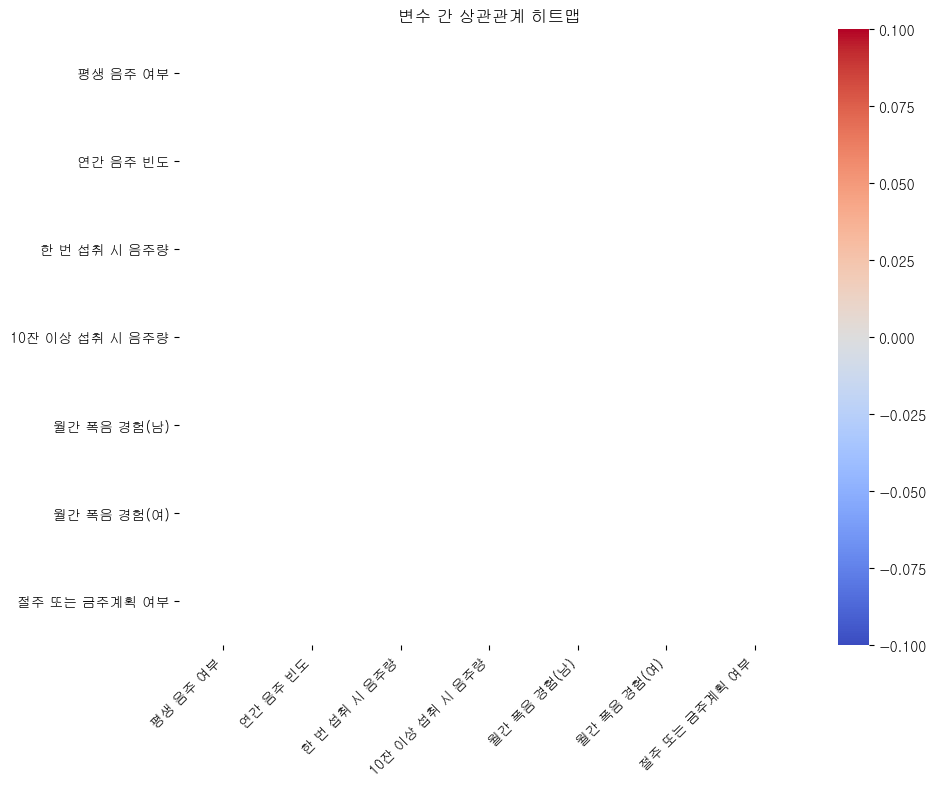

In [68]:
# 평생 음주 여부 ~ 절주 또는 음주계획 여부 칼럼에서 7이상의 값 (비해당, 모름 등의 설문답 삭제)은 제외
# row 존재x 상관계수 분석 불가!!

sub_columns = dict(list(columns.items())[:7])

# 사용할 칼럼만 추출
cols_to_check = list(sub_columns.keys())

# 7 미만 값만 남기기
df_filtered = dr_ph_df[(dr_ph_df[cols_to_check] < 7).all(axis=1)]

corr = df_filtered[cols_to_check].corr()

corr.rename(index=sub_columns, columns=sub_columns, inplace=True)

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('변수 간 상관관계 히트맵')
plt.show()

churn과의 상관계수
- 절주 또는 금주계획 여부가 그나마 0.15로 높은 값
- 연간 음주 빈도 -0.15